# **Import the Necessary Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

# **Load The Train and Test Sets**

In [2]:
"""

Input: The path to the train and test datasets.
Output: DataLoaders for the train and test datasets.
Functionality:
                - Loads the datasets from the specified paths.
                - Converts string representations of lists in the 'info_vector' and 'new_state' columns to actual lists.
                - Constructs input features (X) as a 5D vector containing coordinates and relative speed.
                - Constructs the target variable for regression (y_reg) as the relative speed at t'.
                - Constructs the target variable for classification (y_cls) as labels for LOS/NLOS/NLOSv based on the conditions specified.
                - Reshapes the input for RNN processing.

"""

def process_data(file_path, input_size = 5):
    df = pd.read_csv(file_path) # Load the dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device for PyTorch
    print(f"Processing data from {file_path} on device: {device}")

    info_vector = [ast.literal_eval(item) for item in tqdm(df['info_vector'])] # Convert string representation of lists to actual lists
    new_state = [ast.literal_eval(item) for item in tqdm(df['new_state'])] # Convert string representation of lists to actual lists

    # X: input features (5D vector: coord1[x,y], coord2[x,y], rel_speed)
    X = torch.tensor([
        list(coord1) + list(coord2) + [rel_speed]
        for coord1, coord2, rel_speed in info_vector
    ], dtype=torch.float32).to(device)  # Convert to tensor and move to device

    ################################################################################################################################################################################

    # y_reg: relative speed at t'
    y_reg = torch.tensor([ns[2] for ns in new_state], dtype=torch.float32).view(-1, 1).to(device)  # Convert to tensor and move to device

    ################################################################################################################################################################################

    # Reshape input for RNN: [N, seq_len=1, input_size]
    X_seq = X.view(-1, 1, input_size)

    return TensorDataset(X_seq, y_reg)  # Return TensorDataset containing input features and target variable for regression

####################################################################################################################################################################################

# Path to the train and test datasets

train_path = 'C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_highway_dataset.csv'
test_path = 'C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/test_highway_dataset.csv'

# Create DataLoaders
train_dataset = process_data(train_path)
test_dataset = process_data(test_path)

Processing data from C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_highway_dataset.csv on device: cuda


100%|██████████| 1500000/1500000 [00:35<00:00, 42347.42it/s]


Processing data from C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/test_highway_dataset.csv on device: cuda


100%|██████████| 8113281/8113281 [05:29<00:00, 24601.58it/s] 


# **RNN**

## **Training**

cuda
Total parameters: 1056769
Trainable parameters: 1056769


 10%|█         | 1/10 [00:12<01:50, 12.26s/it]

Epoch 1 Loss:  73.01609623098535


 20%|██        | 2/10 [00:24<01:36, 12.06s/it]

Epoch 2 Loss:  38.3123119637421


 30%|███       | 3/10 [00:38<01:31, 13.12s/it]

Epoch 3 Loss:  22.522153311377906


 40%|████      | 4/10 [01:23<02:34, 25.70s/it]

Epoch 4 Loss:  13.57077066072425


 50%|█████     | 5/10 [01:53<02:16, 27.25s/it]

Epoch 5 Loss:  4.915998010698439


 60%|██████    | 6/10 [02:39<02:14, 33.51s/it]

Epoch 6 Loss:  1.1820969596861166


 70%|███████   | 7/10 [02:52<01:20, 26.75s/it]

Epoch 7 Loss:  0.5822588188452932


 80%|████████  | 8/10 [03:07<00:46, 23.21s/it]

Epoch 8 Loss:  0.47901017650605876


 90%|█████████ | 9/10 [04:02<00:33, 33.02s/it]

Epoch 9 Loss:  0.47233212867897933


100%|██████████| 10/10 [04:17<00:00, 25.78s/it]

Epoch 10 Loss:  0.4220317276773192


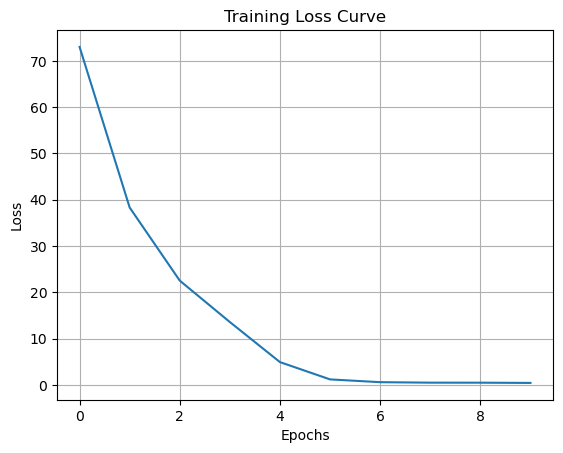

In [10]:
class RNN(nn.Module):
    def __init__(self, hidden_size, input_size = 5, output_size = 1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            batch_first = True
        )
        self.reg_head = nn.Sequential(nn.Linear(hidden_size, output_size))  # for continuous output

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take the output from the last time step
        return self.reg_head(out)

# Hyperparameters

hidden_size = 1024
num_epochs = 10 # Number of epochs for training
lr = 1e-4 # Learning rate for the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024  # Define batch size

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = RNN(hidden_size).to(device)
print(device)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()
loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()

    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/rnn_highway.pth')

# Plot the loss curve

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/rnn_highway_loss_curve.svg')
plt.show()

## **Testing**

In [11]:
model = RNN(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/rnn_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")
error = abs(np.array(prediction_list) - np.array(target_list))

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': error
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/rnn_highway_predictions.csv', index=False)

Testing: 100%|██████████| 7924/7924 [01:29<00:00, 88.25batch/s] 


Regression MAE: 0.6139


In [12]:
model = RNN(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/rnn_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Train Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/rnn_highway_predictions_train.csv', index=False)

Testing: 100%|██████████| 1465/1465 [00:11<00:00, 122.28batch/s]


Train Regression MAE: 1.6083


# **LSTM**

## **Training**

cuda
Total parameters: 1063425
Trainable parameters: 1063425


  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:36<08:32, 36.61s/it]

Epoch 1 Loss:  84.0490155893788


 13%|█▎        | 2/15 [01:16<08:23, 38.72s/it]

Epoch 2 Loss:  65.93694773273663


 20%|██        | 3/15 [01:31<05:30, 27.57s/it]

Epoch 3 Loss:  49.418528202043866


 27%|██▋       | 4/15 [01:46<04:09, 22.70s/it]

Epoch 4 Loss:  34.06746822945494


 33%|███▎      | 5/15 [02:00<03:17, 19.79s/it]

Epoch 5 Loss:  25.59114899597172


 40%|████      | 6/15 [02:15<02:41, 17.98s/it]

Epoch 6 Loss:  20.917743901440513


 47%|████▋     | 7/15 [02:30<02:16, 17.01s/it]

Epoch 7 Loss:  16.129378733155875


 53%|█████▎    | 8/15 [02:50<02:06, 18.11s/it]

Epoch 8 Loss:  11.331846008167535


 60%|██████    | 9/15 [03:31<02:30, 25.01s/it]

Epoch 9 Loss:  6.621398757596472


 67%|██████▋   | 10/15 [03:46<01:50, 22.19s/it]

Epoch 10 Loss:  2.8239158208866577


 73%|███████▎  | 11/15 [04:02<01:20, 20.15s/it]

Epoch 11 Loss:  1.0921935316442222


 80%|████████  | 12/15 [04:18<00:56, 18.74s/it]

Epoch 12 Loss:  0.6056936682440315


 87%|████████▋ | 13/15 [04:33<00:35, 17.77s/it]

Epoch 13 Loss:  0.469413657227067


 93%|█████████▎| 14/15 [04:48<00:16, 16.92s/it]

Epoch 14 Loss:  0.423494624521952


100%|██████████| 15/15 [05:03<00:00, 20.27s/it]

Epoch 15 Loss:  0.39917319393605505


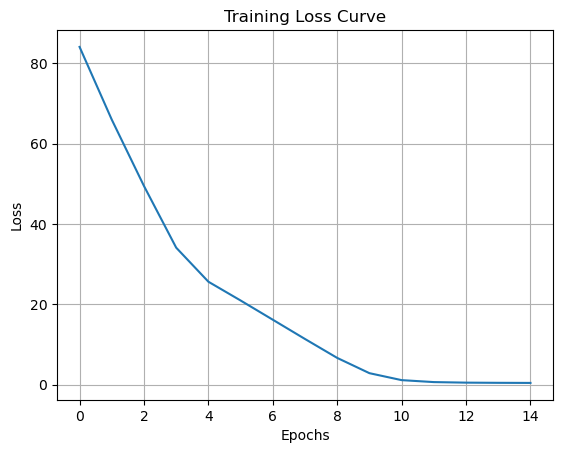

In [22]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, input_size = 5, output_size = 1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.reg_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        reg_out = self.reg_head(out)
        return reg_out

# Hyperparameters

hidden_size = 512
num_epochs = 15
lr = 1e-4 # Learning rate for the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512 # Define batch size

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = LSTM(hidden_size).to(device)
print(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/lstm_highway.pth')

# Plot the loss curve
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/lstm_highway_loss_curve.svg')
plt.show()

## **Testing**

In [23]:
model = LSTM(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/lstm_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/lstm_highway_predictions.csv', index=False)

Testing: 100%|██████████| 15847/15847 [01:39<00:00, 159.36batch/s]


Regression MAE: 0.3733


In [24]:
model = LSTM(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/lstm_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/lstm_highway_predictions_train.csv', index=False)

Testing: 100%|██████████| 2930/2930 [00:13<00:00, 215.30batch/s]


Regression MAE: 0.6094


# **GRU**

## **Training**

cuda
Total parameters: 1093201
Trainable parameters: 1093201


  7%|▋         | 1/15 [00:16<03:45, 16.12s/it]

Epoch 1 Loss:  72.21532759031744


 13%|█▎        | 2/15 [00:32<03:32, 16.32s/it]

Epoch 2 Loss:  36.436342594363175


 20%|██        | 3/15 [00:48<03:14, 16.20s/it]

Epoch 3 Loss:  21.07610479532757


 27%|██▋       | 4/15 [01:04<02:57, 16.16s/it]

Epoch 4 Loss:  10.925511626797528


 33%|███▎      | 5/15 [01:21<02:43, 16.34s/it]

Epoch 5 Loss:  2.670545334152801


 40%|████      | 6/15 [01:37<02:27, 16.39s/it]

Epoch 6 Loss:  0.6380531216949327


 47%|████▋     | 7/15 [01:54<02:10, 16.34s/it]

Epoch 7 Loss:  0.4344668103922349


 53%|█████▎    | 8/15 [02:10<01:53, 16.20s/it]

Epoch 8 Loss:  0.3941745615249608


 60%|██████    | 9/15 [02:26<01:37, 16.22s/it]

Epoch 9 Loss:  0.37732070125003725


 67%|██████▋   | 10/15 [02:42<01:21, 16.33s/it]

Epoch 10 Loss:  0.37508389155409033


 73%|███████▎  | 11/15 [03:00<01:06, 16.59s/it]

Epoch 11 Loss:  0.36638726309806413


 80%|████████  | 12/15 [03:16<00:49, 16.62s/it]

Epoch 12 Loss:  0.36035597808531933


 87%|████████▋ | 13/15 [03:33<00:33, 16.54s/it]

Epoch 13 Loss:  0.3606718082120801


 93%|█████████▎| 14/15 [03:50<00:16, 16.67s/it]

Epoch 14 Loss:  0.36339173441047146


100%|██████████| 15/15 [04:07<00:00, 16.47s/it]

Epoch 15 Loss:  0.3604287865066284


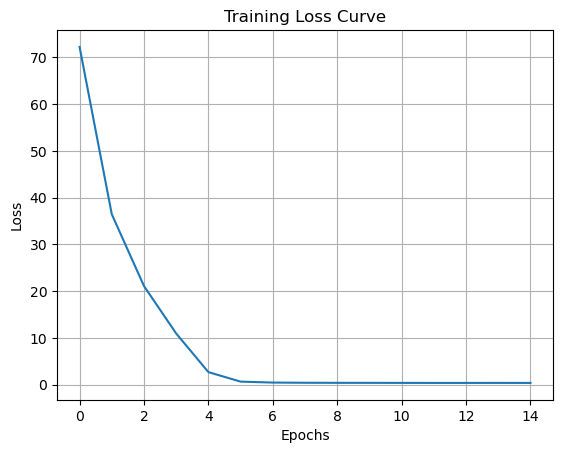

In [25]:
class GRU(nn.Module):
    def __init__(self, hidden_size, input_size = 5, output_size = 1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.reg_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hn = self.gru(x)
        out = out[:, -1, :]
        reg_out = self.reg_head(out)
        return reg_out

# Hyperparameters

hidden_size = 600
num_epochs = 15
lr = 1e-4 # Learning rate for the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512  # Define batch size

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = GRU(hidden_size).to(device)
print(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss+ loss.item()
    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/gru_highway.pth')

# Plot the loss curve

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/gru_highway_loss_curve.svg')
plt.show()

## **Testing**

In [26]:
model = GRU(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/gru_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/gru_highway_predictions.csv', index=False)

Testing: 100%|██████████| 15847/15847 [01:14<00:00, 212.64batch/s]


Regression MAE: 0.3954


In [27]:
model = GRU(hidden_size).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/gru_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/gru_highway_predictions_train.csv', index=False)

Testing: 100%|██████████| 2930/2930 [00:15<00:00, 194.38batch/s]


Regression MAE: 0.7292


# **Transformer**

## **Training**

cuda
Total parameters: 1424753
Trainable parameters: 1424753


 10%|█         | 1/10 [00:53<08:00, 53.38s/it]

Epoch 1 Loss:  83.27778855541867


 20%|██        | 2/10 [01:49<07:20, 55.06s/it]

Epoch 2 Loss:  50.21144787581707


 30%|███       | 3/10 [02:47<06:33, 56.22s/it]

Epoch 3 Loss:  25.36324130162444


 40%|████      | 4/10 [03:45<05:41, 56.91s/it]

Epoch 4 Loss:  11.959641225102004


 50%|█████     | 5/10 [05:10<05:36, 67.28s/it]

Epoch 5 Loss:  2.8765730439192607


 60%|██████    | 6/10 [06:46<05:08, 77.05s/it]

Epoch 6 Loss:  2.097526438000259


 70%|███████   | 7/10 [07:56<03:43, 74.62s/it]

Epoch 7 Loss:  1.8668520774450725


 80%|████████  | 8/10 [09:00<02:22, 71.22s/it]

Epoch 8 Loss:  1.7063840937085526


 90%|█████████ | 9/10 [10:26<01:15, 75.89s/it]

Epoch 9 Loss:  1.6307114840977834


100%|██████████| 10/10 [11:20<00:00, 68.08s/it]

Epoch 10 Loss:  1.6797815334878277


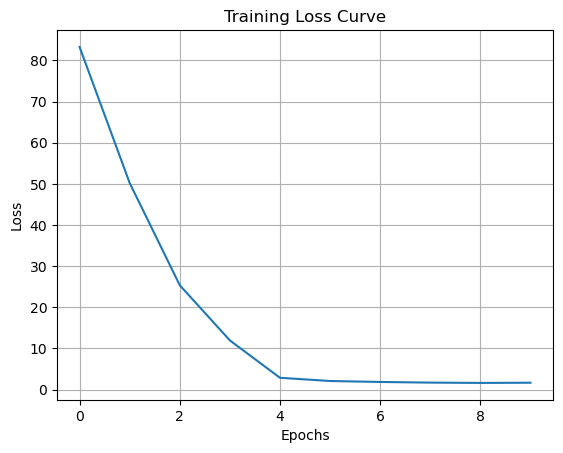

In [24]:
class Transformer(nn.Module):
    def __init__(self, hidden_size, num_heads, num_layers, input_size = 5, output_size = 1, dropout=0.1):
        super(Transformer, self).__init__()

        self.input_proj = nn.Linear(input_size, hidden_size)  # project input to model dim
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.reg_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_proj(x)                     # (batch, seq_len, hidden)
        x = self.transformer_encoder(x)            # (batch, seq_len, hidden)
        x = x[:, -1, :]                            # take last time step
        reg_out = self.reg_head(x)
        return reg_out

# Hyperparameters

hidden_size = 80
num_heads = 4
num_layers = 4
num_epochs = 10
lr = 1e-4 # Learning rate for the optimizer
batch_size = 512  # Define batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

####################################################################################################################################################################################

# Create DataLoaders for training and testing datasets

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

####################################################################################################################################################################################

# Instantiate model

model = Transformer(hidden_size, num_heads, num_layers).to(device)
print(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
regression_loss_fn = nn.L1Loss()

# Total number of parameters

total_params = sum(p.numel() for p in model.parameters())

# Only trainable parameters

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

####################################################################################################################################################################################

loss_list = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    total_loss = 0.0
    for batch_x, batch_y_reg in train_loader:
        
        reg_out = model(batch_x)

        loss = regression_loss_fn(reg_out, batch_y_reg)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()
    print("Epoch", epoch + 1, "Loss: ", total_loss / len(train_loader))
    loss_list.append(total_loss / len(train_loader))

# Save the model
torch.save(model.state_dict(), 'C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/transformer_highway.pth')

# Plot the loss curve

plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Train Plots/transformer_highway_loss_curve.svg')
plt.show()

## **Testing**

In [26]:
model = Transformer(hidden_size, num_heads, num_layers).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/transformer_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(test_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/transformer_highway_predictions.csv', index=False)

Testing: 100%|██████████| 15847/15847 [03:37<00:00, 72.94batch/s]


Regression MAE: 5.3676


In [27]:
model = Transformer(hidden_size, num_heads, num_layers).to(device)
model.load_state_dict(torch.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/transformer_highway.pth'))
model.eval()

prediction_list = []
target_list = []

with torch.no_grad():
    for x_batch, y_reg_batch in tqdm(train_loader, desc="Testing", unit="batch"):
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)

        reg_out = model(x_batch)

        # Collect predictions and targets

        prediction_list.extend(reg_out.view(-1).cpu().numpy())
        target_list.extend(y_reg_batch.view(-1).cpu().numpy())

# Compute metrics
mae = mean_absolute_error(target_list, prediction_list)
print(f"Regression MAE: {mae:.4f}")

# Save predictions and targets to CSV
predictions_df = pd.DataFrame({
    'Predictions': prediction_list,
    'Targets': target_list,
    'Error': abs(np.array(prediction_list) - np.array(target_list))
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/transformer_highway_predictions_train.csv', index=False)

Testing: 100%|██████████| 2930/2930 [00:32<00:00, 90.77batch/s] 


Regression MAE: 9.5960
